# Chapter 3: Classification

## Exercise 1: Build a classifier of MNIST with an accuracy over 97%

Let's start by downloading the data and get the images and labels

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml(name='mnist_784', version=1, as_frame=False, parser='auto')
mnist.keys()

In [ ]:
x = mnist['data']
y = mnist['target']

Now that we got the the features and targets we can analyze the data

In [ ]:
import pandas as pd

y_series = pd.Series(y)
y_series.value_counts().plot.pie()

As we can see the target values ranges from 0 to 9 and they are balanced. Also, we don´t have NaN values.
<p> Let's have a look to the actual images

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


fig, axs= plt.subplots(5, 5)
fig.subplots_adjust(hspace=.5, wspace=.001)


for image, label, ax in zip(x, y, axs.ravel()):
    ax.imshow(np.reshape(image, (28, 28)), cmap='binary')
    ax.set_title(label)
    ax.axis('off')
        

Before starting with the classifier, I think it's a good idea to visualize the structure of the data. <br> Do to so, we can use 2 technics:
- Principal Components Analysis
- t-distributed stochastic neighbor embedding

### Principal Components Analysis

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
scores = pca.fit_transform(x)

df_pca = pd.DataFrame(np.hstack((scores, y.reshape(-1, 1))), columns=['Principal Component 1', 'Principal Component 2', 'label'])
df_pca.head()

In [ ]:
import seaborn as sns

sns.scatterplot(df_pca, x='Principal Component 1', y='Principal Component 2', hue='label')
plt.title('PCA')
plt.show()

### t-SNE

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_jobs=-1, perplexity=50, n_iter=300)
scores_tsne = tsne.fit_transform(x)

df_tsne = pd.DataFrame(np.hstack((scores_tsne, y.reshape(-1, 1))), columns=['tsne 1', 'tsne 2', 'label'])

sns.scatterplot(df_tsne, x='tsne 1', y='tsne 2', hue='label')
plt.title('t-SNE')
plt.show()

### Model training

Before starting training the models, we need to split the data into calibration and testing set. Since the dataset is balanced we don't need to use stratified strategies.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

As we can see either on PCA or t-SNE, the data this clustered into groups. Because of that, KNN may be a good model

<b> WARNING: </b> Run this cell is very slow

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# Create the model
knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

# Params 
param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]
score = cross_val_score(knn, X_train, y_train, cv=5, scoring="accuracy", n_jobs=-1)


## Titanic Dataset

The objective is to classify if a passenger would survived or not

In [41]:
import pandas as pd

train_data = pd.read_csv(r'./datasets/titanic/train.csv')
test_data = pd.read_csv(r'./datasets/titanic/test.csv')

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


From the documentation of the dataset:
- <b>Pclass:</b> Socio-economic class (1 = Upper class; 2 = Middle class; 3 = Lower class)
- <b> Name:</b> Passenger Name
- <b> Sex:</b> Passenger Sex
- <b> Age:</b> Passenger Age
- <b> SibSp </b> Number of siblings & spouses of the passenger on board 
- <b> Parch </b> Number of parent and children of the passenger on board  
- <b> Ticket </b> Ticket Number of the Passenger 
- <b> Fare </b> Price paid (pounds)
- <b> Cabin </b> Cabin number of the passenger
- <b> embarked </b> Port of embarkation of the passenger (C = Cherbourg; Q = Queenstown; S = Southampton)

Some features doesn't add information to the model such as:
- name
- Ticket

Let's start by changing the PassengerID to the index. Then we'll remove the names colum 

In [43]:
train_data.set_index('PassengerId', inplace=True)
test_data.set_index('PassengerId', inplace=True)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In the training set we have 891 different passengers.
<br> In some features we have missing data:

- Age: 177 missing values
- Cabin: 688 missing values
- Embarked: 2 missing values

Since the cabin has 70% of Nan values, we decided to eliminated.
<br> For the Age feature, we can add the median values to the missing data, it is the easiest approach. Other solution would be to predict the age based on the other features, such as Pclass and Sex. To keep the think simple, we'll use the median of all values 

In [62]:
for p_class in train_data['Pclass'].unique():
    age = train_data[train_data['Pclass'] == p_class]['Age'].median()
    print(f'{p_class}_class median age {age :.2f}')

print('Total median age: ',  train_data['Age'].median())

3_class median age 24.00
1_class median age 37.00
2_class median age 29.00
Total median age:  28.0


In [52]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- Only 38% Survived. Accuracy may be a reasonable metric to evaluate the model performance. Although the dataset is unbalanced
- The ages ranges from 6 months to 80 years-old, nut the mean age was less than 30 years-old
- The median fare is 32 pounds.

Let's look at the category features:
- Pclass
- Sex
- Embarked


<Axes: title={'center': 'Pclass'}, ylabel='Pclass'>

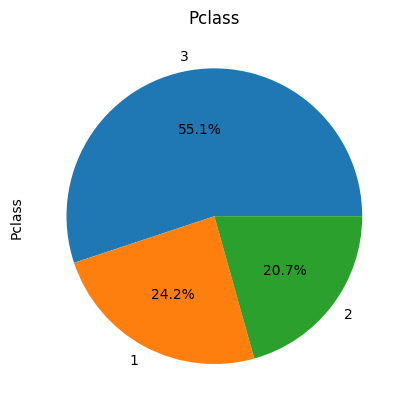

In [58]:
train_data['Pclass'].value_counts().plot.pie(title='Pclass', autopct='%1.1f%%')

<Axes: title={'center': 'Sex'}, ylabel='Sex'>

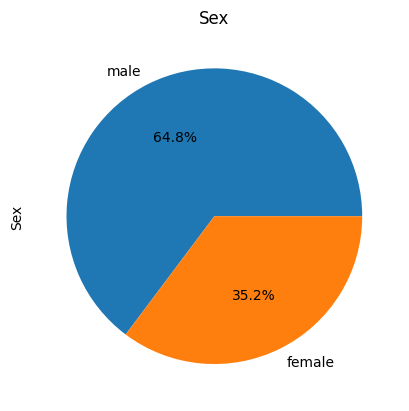

In [57]:
train_data['Sex'].value_counts().plot.pie(title='Sex', autopct='%1.1f%%')

<Axes: title={'center': 'Sex'}, ylabel='Embarked'>

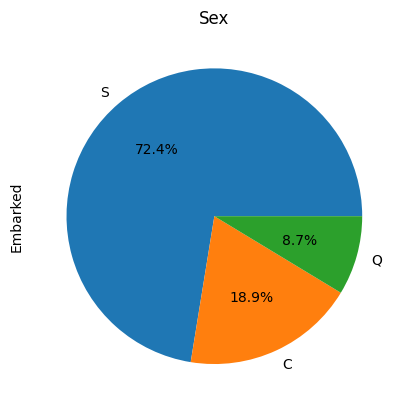

In [ ]:
train_data['Embarked'].value_counts().plot.pie(title='Sex', autopct='%1.1f%%')

We can see that the majority of the passengers were man, from the 3rd class that embarked at Southampton

In [60]:
train_data[train_data['Sex']=='male']['Survived'].value_counts()

0    468
1    109
Name: Survived, dtype: int64

In [61]:
train_data[train_data['Sex']=='female']['Survived'].value_counts()

1    233
0     81
Name: Survived, dtype: int64

We can also notice that 74% of the women survived and only 18% were saved. This results make sense because the children and womans were the first ones to go to the rescue vessel.
<br> It's expected that the <b>Sex</b> feature to have a greater contribution 

Let's start to prepare the data to feed the ML model.
<br> For the numerical values we need:

- replace the missing values on with the mean
- Scale the data (StandardScaler: x-men/st, column wise)

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

numerical_pipeline = Pipeline([
                            ('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())
                            ])

Now we build the pipeline for the categorical features, which consists in adding the most frequente values in the missing values. In the training set we don't have missing values on the categorical features, but in real case applications we might have, so we need to make the pipeline robust.
<br> Then, we need to one hot encode all the categories.

In [65]:
from sklearn.preprocessing import OneHotEncoder

categorical_pipeline = Pipeline([
                                ('imputer', SimpleImputer(strategy='most_frequent')),
                                ('cat_encoder', OneHotEncoder())
                                ])

Finally we create the preprocessing pipeline

In [69]:
from sklearn.compose import ColumnTransformer

num_attributes = ["Age", "SibSp", "Parch", "Fare"]
cat_attributes = ["Pclass", "Sex", "Embarked"]

preprocessing_pipeline = ColumnTransformer([('numerical', numerical_pipeline, num_attributes),
                                            ('categorical', categorical_pipeline, cat_attributes)
                                            ])
preprocessing_pipeline

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'SibSp', 'Parch', 'Fare']),
                                ('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('cat_encoder',
                                                  OneHotEncoder())]),
                                 ['Pclass', 'Sex', 'Embarked'])])

Now that we created the 'preprocessing_pipeline' we can transform the training features and starting testing some ML models! :D

In [78]:
x_train = train_data[num_attributes + cat_attributes]
y_train = train_data['Survived']

x_test = test_data[num_attributes + cat_attributes]

x_train

,Age,SibSp,Parch,Fare,Pclass,Sex,Embarked
PassengerId,,,,,,,
1,22.0,1,0,7.2500,3,male,S
2,38.0,1,0,71.2833,1,female,C
3,26.0,0,0,7.9250,3,female,S
4,35.0,1,0,53.1000,1,female,S
5,35.0,0,0,8.0500,3,male,S
...,...,...,...,...,...,...,...
887,27.0,0,0,13.0000,2,male,S
888,19.0,0,0,30.0000,1,female,S
889,NaN,1,2,23.4500,3,female,S


In [74]:
x_train_preprocessed = preprocessing_pipeline.fit_transform(x_train)
x_train_preprocessed

array([[-0.56573582,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.6638609 ,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.10463705,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276213, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

Now we are ready to train some models. 
Let's start with RandomForest

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score


forest_clf = RandomForestClassifier(random_state=42)

forest_scores = cross_val_score(forest_clf, x_train_preprocessed, y_train, 
                                cv=10, scoring="accuracy", n_jobs=-1)
print("Cross-validation Accuracy: ", forest_scores.mean())

Accuracy:  0.8137578027465668


In [83]:
forest_clf.fit(x_train_preprocessed, y_train)
y_pred = forest_clf.predict(x_train_preprocessed)
print('Calibration Accuracy: ', accuracy_score(y_true=y_train, y_pred=y_pred))

Calibration Accuracy:  0.9797979797979798


As we can see the model is slightly overfited to the calibration data. We could try grid search to try to improve the accuracy, but the model will overfit even harder. So we can try less complex models such as SVC or KNN

In [85]:
from sklearn.svm import SVC

svm_clf = SVC()

svm_scores = cross_val_score(svm_clf, x_train_preprocessed, y_train, 
                             cv=10, scoring="accuracy", n_jobs=-1)

print("Cross-validation Accuracy: ", svm_scores.mean())
svm_clf.fit(x_train_preprocessed, y_train)
y_pred = svm_clf.predict(x_train_preprocessed)
print('Calibration Accuracy: ', accuracy_score(y_true=y_train, y_pred=y_pred))

Cross-validation Accuracy:  0.8249438202247191
Calibration Accuracy:  0.8383838383838383


How the model is not overfited, we can try to improve by fine-tuning the hyper-parameters

In [86]:
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001, 'auto'], 'kernel': ['rbf']},
 ]

grid_search = GridSearchCV(svm_clf, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)
grid_search.fit(x_train_preprocessed, y_train)

GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000],
                          'gamma': [0.001, 0.0001, 'auto'],
                          'kernel': ['rbf']}],
             scoring='accuracy')

In [89]:
print("Cross-validation Accuracy: ", grid_search.best_score_.mean())
y_pred = grid_search.predict(x_train_preprocessed)
print('Calibration Accuracy: ', accuracy_score(y_true=y_train, y_pred=y_pred))
print(confusion_matrix(y_train, y_pred))

Cross-validation Accuracy:  0.8294257178526842
Calibration Accuracy:  0.8428731762065096
[[524  25]
 [115 227]]


To improve the model we can try:
- Create new features like:
    - Ages Categorical
    - Convert Fare to Categorical 
    - Family Size: Parch + SibSp
    - isAlone: Family_Size = 1
    - Age*class 
- Apply transformations to numeric features so it can have a more normal shape


## Spam Dataset

Try to build a scam classifier 

The first step is to download the data. Remember that HAM is an email that is not spam.

In [3]:
import os 
import urllib.request
import tarfile


DOWNLOAD_ROOT = "https://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20021010_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

# Fetch data
if not os.path.isdir(SPAM_PATH):
    os.makedirs(SPAM_PATH)
for filename, url in (('ham.tar.bz2', HAM_URL), ('spam.tar.bz2', SPAM_URL)):
    path = os.path.join(SPAM_PATH, filename)
    if not os.path.isfile(path):
        urllib.request.urlretrieve(url, path)
    tar_bz2_file = tarfile.open(path)
    tar_bz2_file.extractall(path=SPAM_PATH)
    tar_bz2_file.close()

Now let's load all emails

In [8]:
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")

ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [9]:
len(ham_filenames)

2500

Now lets see the structure of the data

In [10]:
import email
from email import policy

def load_email(is_spam: bool, filename: os.path, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=policy.default).parse(f)
    

In [11]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

In [13]:
print(ham_emails[10].get_content().strip())

Hello, have you seen and discussed this article and his approach?

Thank you

http://www.paulgraham.com/spam.html
-- "Hell, there are no rules here-- we're trying to accomplish something."
-- Thomas Alva Edison




-------------------------------------------------------
This sf.net email is sponsored by: OSDN - Tired of that same old
cell phone?  Get a new here for FREE!
https://www.inphonic.com/r.asp?r=sourceforge1&refcode1=vs3390
_______________________________________________
Spamassassin-devel mailing list
Spamassassin-devel@lists.sourceforge.net
https://lists.sourceforge.net/lists/listinfo/spamassassin-devel
